Gesture Typing 
===

Typing quickly and accurately on a smartphone screen is hard! One invention to make it easier is **gesture typing**, in which your finger can trace a **path** consisting of letter-to-letter **segments**. When you lift your finger the path (and the word) is complete. Below we see the path for the word "hello." Note that the path is imprecise; it didn't quite hit the "L", but the word was recognized anyways, because "Hello" is a known word, whereas "Hekko", "Hwerklo", etc., are not.

<img src="http://norvig.com/gesture.png">

Questions About Gesture Typing
===

My colleague Nicolas Schank examined (and answered) the question of what word has the longest path length. I mentioned this to [Shumin Zhai](http://www.shuminzhai.com/), the pioneer of gesture typing, and between the three of us we expanded the list of questions:

 1. What words have the longest path length?
 2. What words have the highest ratio of path length to word length? 
 3. What is the average segment length, over a typical typing work load?
 3. Is there a better keyboard layout to minimize the average segment length over a work load?
 4. How often are two words confused because they have similar paths?
 5. Is there a better keyboard layout to minimize confusion? 
 6. Is there a better keyboard layout to maximize overall user satisfaction?

Let's look at each of these questions, but first, let's get a rough idea for of the concepts we will need to model.

Vocabulary
===

We will need to talk about the following concepts:

* **Keyboard**: We'll need to know the **location** of each letter on the keyboard (we consider only letters, not the other symbols).
* **Location**: A location is a **point** in two-dimensional space (we assume keyboards are flat).
* **Path**: A path connects the letters in a word. In the picture above the path is curved, but a shortest path is formed by connecting straight line **segments**, so maybe we need only deal with straight lines.
* **Segment**: A line segment is a straight line between two points.
* **Words**: We will need a list of allowable words (in order to find the one with the longest path).
* **Work Load**: If we want to find the average path length over a typical work load, we'll have to represent a work load: not
just a list of words, but a measure of how frequent each word is.
* **Confusion**: We need some measure of *whether* (or perhaps *to what degree*) the paths for two words can be confused with each other.
* **Satisfaction**: This is a very difficult concept to define.  A user will be more satisfied with a keyboard if it allows for fast, accurate typing, and if it gives the user a feeling of mastery, not frustration.

**Note**: Before we get started writing any real code, I've taken all the imports I will need throughout this notebook and gathered them together here:


             

In [1]:
%pylab --no-import-all inline
from __future__ import division
from collections import Counter
import matplotlib.pyplot as plt
import urllib
import itertools
import random 
import re

Populating the interactive namespace from numpy and matplotlib


Representing Keyboards and Points
===

The representation for a keyboard needs to describe the location of each of the letters. Using the principle of *"Do the simplest thing that could possibly work,"* I represent a keyboard as a `dict` of `{letter: point}` pairs, where there will be 26 letters, A-Z,
and each point will mark the x-y coordinates of the center of the corresponding key.  In a standard keyboard the letters are not all on a strict rectangular grid; the **A** key is half way between the **Q** and **W** in the horizontal direction. I would like to have a programmer-friendly way of defining keyboard layouts.  For example, a programmer should be able to write:

    Keyboard(('Q W E R T Y U I O P',
              ' A S D F G H J K L ',
              '   Z X C V B N M   '))
              
and this would be equivalent to the `dict`:

    {'Q': Point(0, 0),   'W': Point(1, 0), ...
     'A': Point(0.5, 1), 'S': Point(1.5, 1), ...
     'Z': Point(1.5, 2), 'X': Point(2.5, 2), ...}
              
Note that one key width is two characters in the input to `Keyboard`.  Here is the implementation:

In [2]:
def Keyboard(rows):
    "A keyboard is a {letter: location} map, e.g. {'Q':Point(0, 0), 'A': Point(0.5, 1)}."
    return {ch: Point(x/2, y) 
            for (y, row) in enumerate(rows)
            for (x, ch) in enumerate(row)
            if ch != ' '}

What about `Point`? At first glance, Python does not appear to have a two-dimensional point as a builtin data type, but
on second thought, it does: `complex`. A complex number is a point in the two-dimensional complex plane;
we can use that to model the two-dimensional (x, y) plane. Because complex numbers are built in, manipulating them will be efficient. A bonus is that the distance between points `A` and `B` is simply  `abs(A-B)`; easier than the usual formula involving squares and a square root. Thus, the simplest possible thing I could do to represent points is

<pre>
Point = complex
</pre>

That would work fine. However, I would like to refer to the x coordinate of point `p` as `p.x` rather than `p.real`, and I would like points to display nicely, so I will do the second-simplest thing: make `Point` be a subclass of `complex` with `x` and `y` properties and a  `__repr__` method:

In [3]:
class Point(complex):
    "A point in the (x, y) plane."
    def __repr__(self): return 'Point({}, {})'.format(self.x, self.y)
    x = property(lambda p: p.real)
    y = property(lambda p: p.imag)
    
def distance(A, B):
    "The distance between two points."
    return abs(A - B)

**Design notes for Point:** Alternative representations for points include an `(x, y)` tuple, or a NumPy two-element array, or a namedtuple. 

**Design notes for Keyboard:** Alternatives for `Keyboard` include a subclass of `dict`, or a class that contains a `dict`.  
I considered support for keyboards
in which one row is, say, offset 1/3 of a key rather than 1/2 key from the row above. In the end I decided to keep the function `Keyboard` as simple as possible; you can always define a function, `FancyKeyboard`, if you want more.

Now we can check that `Keyboard` works:

In [4]:
qwerty = Keyboard(('Q W E R T Y U I O P',
                   ' A S D F G H J K L ',
                   '   Z X C V B N M   '))
qwerty

{'A': Point(0.5, 1.0),
 'B': Point(5.5, 2.0),
 'C': Point(3.5, 2.0),
 'D': Point(2.5, 1.0),
 'E': Point(2.0, 0.0),
 'F': Point(3.5, 1.0),
 'G': Point(4.5, 1.0),
 'H': Point(5.5, 1.0),
 'I': Point(7.0, 0.0),
 'J': Point(6.5, 1.0),
 'K': Point(7.5, 1.0),
 'L': Point(8.5, 1.0),
 'M': Point(7.5, 2.0),
 'N': Point(6.5, 2.0),
 'O': Point(8.0, 0.0),
 'P': Point(9.0, 0.0),
 'Q': Point(0.0, 0.0),
 'R': Point(3.0, 0.0),
 'S': Point(1.5, 1.0),
 'T': Point(4.0, 0.0),
 'U': Point(6.0, 0.0),
 'V': Point(4.5, 2.0),
 'W': Point(1.0, 0.0),
 'X': Point(2.5, 2.0),
 'Y': Point(5.0, 0.0),
 'Z': Point(1.5, 2.0)}

Computing Path Length
===

Now let's figure out the path length for a word: the sum of the lengths of segments between letters.  So the path length for `'WORD'` would be the sum of the segment lengths for `'WO'` plus `'OR'` plus `'RD'`:

In [5]:
W, O, R, D = qwerty['W'], qwerty['O'], qwerty['R'], qwerty['D'], 
distance(W, O) + distance(O, R) + distance(R, D)

13.118033988749895

Let's make a function to compute this:

In [6]:
def path_length(word, kbd=qwerty):
    "The total path length for a word on this keyboard: the sum of the segment lengths."
    return sum(distance(kbd[word[i]], kbd[word[i+1]])
               for i in range(len(word)-1))

In [7]:
path_length('WORD')

13.118033988749895

Let's check with a simpler example that we know the answer to:

In [8]:
path_length('TO')

4.0

That makes it clearer&mdash;the **O** is four keys to the right of the **T**, on the same row, so the distance between them is 4.

Here's another one that you can verify on your own:

In [9]:
path_length('TYPEWRITER') == 1 + 4 + 7 + 1 + 2 + 4 + 3 + 2 + 1 == 25

True

Question 1: Longest Path Length?
===

To know what the longest word is, we'll have to know what the allowable words are. The so-called TWL06 word list gives all the words that are legal in the game of Scrabble; that seems like a reasonable list (although it omits proper nouns). Here's how to load a copy:

In [2]:
WORDS = set(urllib.urlopen('http://norvig.com/ngrams/TWL06.txt').read().split())

In [3]:
len(WORDS)

21

That's a lot of words; which one has the longest path?

In [12]:
max(WORDS, key=path_length)

'PALEOMAGNETISMS'

And the longest ten paths? Including the lengths? We'll use a helper function, `print_top`, which prints the top *n* items in a seqence according to some key function:

In [13]:
def print_top(n, sequence, key=None, fmt='{:.1f} {}'):
    "Find the top n elements of sequence as ranked by key function, and print them."
    for x in sorted(sequence, key=key, reverse=True)[:n]:
        print(fmt.format(key(x), x))
              
print_top(10, WORDS, path_length)

72.2 PALEOMAGNETISMS
70.0 ANTIQUARIANISMS
69.9 ELECTROANALYSIS
69.9 ANTIAPHRODISIAC
69.3 PARLIAMENTARIAN
68.9 BLEPHAROSPASMS
68.6 BIDIALECTALISMS
67.6 PALEOGEOGRAPHIC
67.6 SPERMATOZOANS
67.1 APOCALYPTICISMS


Question 2: Highest Path Length to Word Length Ratio?
===

Very long words tend to have long path lengths.  But what words have the highest *ratio*
of path length to word length? (I decided to measure word length by number of letters; an alternative is number of segments.) 

In [14]:
def path_length_ratio(word, kbd=qwerty): return path_length(word, kbd) / len(word)

In [15]:
print_top(10, WORDS, path_length_ratio)

6.9 PALAPA
6.7 PAPAL
6.4 PAPA
6.4 JALAPS
6.2 SLAPS
6.2 KAMALA
6.2 LAPELS
6.2 PAPS
6.2 HALALA
6.1 SPALE


Aside: Where did "TYPEWRITER" Come From?
===

How did I find "TYPEWRITER," a long word whose letters are all on the top row?  I could have [looked it up](http://lmgtfy.com/?q=longest+word+typed+all+on+one+row+on+typewriter), but instead I used the following code:

In [16]:
def on_top_row(word): return all(L in 'QWERTYUIOP' for L in word)

print_top(10, filter(on_top_row, WORDS), len)

10.0 PERPETUITY
10.0 PEPPERTREE
10.0 REPERTOIRE
10.0 PREREQUIRE
10.0 PROPRIETOR
10.0 TYPEWRITER
9.0 POTPOURRI
9.0 TERRITORY
9.0 TWITTERER
9.0 PUTTYROOT


Question 3: Average Segment Length on Work Load?
===

What is the average segment length for a typical typing work load? To answer that, we need to know what a typical work load is.

Representing Workloads
---

We will read a file of "typical" text, and count up how many times each segment is used. We'll define a `Workload` as a `dict` of the form `{segment: proportion, ...},` e.g. `{'AB': 0.02}`, where each key is a two-letter string representing a segment, and each value is the proportion of time that segment appears in the workload.  Since the distance from `A` to `B` on a keyboard is the same as the distance from `B` to `A`, we don't need both `AB` and `BA` as keys; we'll combine the counts for both of them under the alphabetically first one (in this case,  `AB`). So `Workload` will first generate all two-character *bigrams* in the text, then filter out the non-alphabetic ones, then take the `segment` of each pair, and count up (with `Counter`) how many times each segment occurs, and finally normalize these counts so that they sum to 1.0, but retain their proportion to each other.

In [17]:
def Workload(text):
    """Create a Workload--a dict of the form {'AB': 1000, ...} 
    saying how often each letter pair occurs in text."""
    pairs = filter(str.isalpha, bigrams(text))
    return normalize(Counter(segment(A, B) for (A, B) in pairs))

def bigrams(sequence):
    "Every sequence of two adjacent elements (overlapping) in sequence."
    return (sequence[i:i+2] for i in range(len(sequence) - 1))
    
def segment(A, B):
    "Canonical two-character segment: segment('A', 'B') == segment('B', 'A') == 'AB'."
    return A+B if (A < B) else B+A

def normalize(dictionary):
    "Normalize a {key: val} dict so that the sum of the vals is 1.0."
    total = sum(dictionary.values())
    for k in dictionary:
        dictionary[k] /= total
    return dictionary

Let's see what a workload looks like for a tiny text:

In [18]:
Workload('SHOT IS GOOD -- GOOOOOOOOOOOAL!')

Counter({'OO': 0.55, 'GO': 0.1, 'DO': 0.05, 'HS': 0.05, 'IS': 0.05, 'AL': 0.05, 'AO': 0.05, 'HO': 0.05, 'OT': 0.05})

I happened to have a file of about a megabyte of random text, `smaller.txt`; that should work fine as a typical work load:

In [13]:
TEXT     = urllib.urlopen('http://norvig.com/ngrams/smaller.txt').read().upper()
WORKLOAD = Workload(TEXT)

AttributeError: module 'urllib' has no attribute 'urlopen'

Let's peek at the most common segments:

In [20]:
WORKLOAD.most_common(10)

[('HT', 0.04144819308354474),
 ('ER', 0.04050225926898767),
 ('EH', 0.03576926529702987),
 ('IN', 0.02699818128015268),
 ('AN', 0.02320447132440709),
 ('NO', 0.022344984888333263),
 ('EN', 0.021994208025641622),
 ('IT', 0.021467211506811055),
 ('ES', 0.020667573255841017),
 ('DE', 0.020619362217840744)]

How many distict segments are there?  

In [21]:
len(WORKLOAD)

283

Now we want to compute the average segment length, on a given keyboard, over all the segments that appear in a workload, so just multiply the length of each segment by the proportion of time it appears and sum these up:

Close enough.  Now we can compute the workload average:

In [12]:
def workload_average(kbd, workload=WORKLOAD):
    "The average segment length over a workload of segments."
    return sum(distance(kbd[A], kbd[B]) * workload[A+B]
               for (A, B) in workload)

NameError: name 'WORKLOAD' is not defined

In [23]:
workload_average(qwerty)

3.2333097802127644

So, on average, your finger has to travel a little over 3 keys from one letter to the next over a typical workload.

Aside: Visualizing a Keyboard
---

We'll need a way of visualizing what a keyboard looks like. I could just `print` letters, but I think it is more compelling to use IPython's `plot` facility. In the function `plot_kbd` we'll draw a square around the center point of each key, and annotate the square with the key letter. In `show_kbd`, we'll call `plot_kbd` and also print out the keyboard's name and workload average:

In [10]:
def plot_kbd(kbd, K=20):
    "Plot the keyboard with square keys, K units on a side."
    H = K / 2       ## (K is Key width/height; H is half K)
    # Draw a square for each key
    for L in kbd:
        x, y = K * kbd[L].x, -K * kbd[L].y
        plot_square(x, y, H, label=L)
    # Show the plot
    plt.axis('equal'); plt.axis('off'); plt.show()

def plot_square(x, y, H, label='', style='k-'):
    "Plot a square with center (x, y), half-width H, and optional label."
    plt.plot([x-H, x+H, x+H, x-H, x-H], 
             [y-H, y-H, y+H, y+H, y-H], style)  
    plt.annotate(label, (x-H/4, y-H/4)) # H/4 seems to place label well.
    
def show_kbd(kbd, name='keyboard'):
    "Plot a keyboard and print statistics about it."
    plot_kbd(kbd)    
    print('workload average = {:.1f} for {}'
          .format(workload_average(kbd), name))

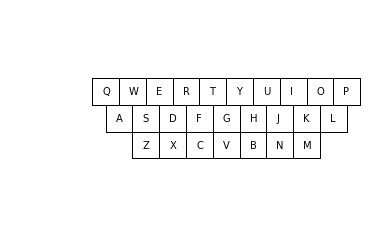

NameError: name 'workload_average' is not defined

In [11]:
show_kbd(qwerty)

Question 4: Keyboard with Minimal Workload Average?
===

Now for a much harder question: can we find a different keyboard layout that has a smaller average segment length over the workload? First, let's note that there are two ways to modify a keyboard:  

* Keep the keys in the same locations but swap letters. (This is an operation you can do on a physical keyboard just by prying off the key caps and swapping them.) 
* Change the locations of keys.  (On a physical keyboard you'd need a saw and glue to do this, but it is easier on a virtual keyboard.)  

Let's start by limiting ourselves to just swapping letters.  

This is an **optimization** problem.  There are many permutations of letters; too many to try them all. To be precise, there are 26! (26 factorial) permutations, which is about 10<sup>26</sup> (fun fact: 25 and 26 are the only integers for which n! &approx; 10<sup>n</sup>).  If we can't try them all, we need some way to sample the configurations, trying to make progress towards a better one. Again, we'll try the simplest thing that could possibly work: 

  1. Pick two keys at random.
  2. Swap them.
  3. If that gives a better (lower) workload total, keep them that way.
  4. If not, swap back.
  5. Repeat this for a given number of times, say 1000.

In [26]:
def improve(kbd, swaps=1000, scorer=workload_average):
    "Minimize scorer(kbd) by swapping keys and keeping improvements."
    score = scorer(kbd)
    letters = list(kbd)
    for _ in range(swaps):
        A, B = random.sample(letters, 2)   # Step 1: pick two keys
        swap(kbd, A, B)                    # Step 2: swap them
        score2 = scorer(kbd)
        if score2 < score:                 # Step 3: If better, keep them
            score = score2                 # (and record the new best total)
        else:
            swap(kbd, B, A)                # Step 4: swap back if not better
    return kbd

def swap(kbd, A, B): kbd[A], kbd[B] = kbd[B], kbd[A]

**Note 1:** This strategy is called **hillclimbing**, drawing on the metaphor of getting to a high peak by trying to take a step, and continuing if the step is uphill, and returning if it is not.  This technique often finds a local maximum&mdash;a solution that is better than all its neighbors, but not as good as another solution that is many steps away.

**Note 2:** I make `scorer` be a parameter, in case we later decide we want to minimize something else other than `workload_average` (such as confusingness).

**Note 3:** The procedure  `improve` modifies its argument.  If you called `improve(qwerty)`, then `qwerty` would be modified. We
probably don't want that. So, in analogy with the built-in function `sorted`, I will define the pure function `improved` to return a new keyboard, without modifying its argument:

In [27]:
def improved(kbd, swaps=1000, scorer=workload_average): 
    "Minimize scorer(kbd) by swapping keys and keeping improvements; don't modify kbd."
    return improve(kbd.copy(), swaps, scorer)

Let's see how well we can do:

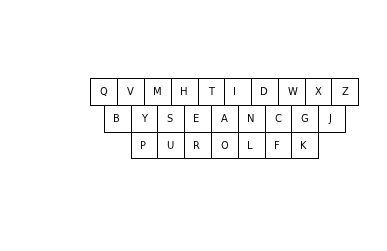

workload average = 1.9 for keyboard


In [28]:
show_kbd(improved(qwerty, 1000))

That's a pretty good improvement! We decreased the workload average  by about a third. (If you are reading this in an active IPython notebook, you can re-run the cell above and see a different result each time.) 

Visualizing `improved`
---

Let's get a better feeling for what `improved` does.  We will keep track of the workload average after each swap, and plot that as a line.  (We know this line should be monotonically decreasing, starting at 3.23.)  We will then plot a dozen instances of this line (different each time because the swaps are random).  

I'll copy-and-paste `improve`   (regrettably violating the [don't repeat yourself](http://en.wikipedia.org/wiki/Don%27t_repeat_yourself) principle), and make `improve_scores`, adding code that yields the average workload after each swap.

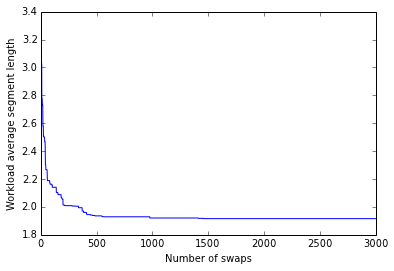

In [29]:
def improve_scores(kbd, swaps=1000, scorer=workload_average):
    "A version of 'improve' that yields the workload average after each swap."
    total = scorer(kbd)
    letters = list(kbd)
    T = sum(WORKLOAD.values())             # <<< NEW
    for _ in range(swaps):
        A, B = random.sample(letters, 2)   # Step 1: pick two keys
        swap(kbd, A, B)                         # Step 2: swap them
        total2 = scorer(kbd)
        if total2 < total:                 # Step 3: If better, keep them
            total = total2                 # (and record the new best total)
        else:
            swap(kbd, B, A)                     # Step 4: swap back if not better
        yield total / T                    # <<< NEW
    
def workload_plot(kbd, swaps):
    plt.ylabel('Workload average segment length') 
    plt.xlabel('Number of swaps');  
    plt.plot(list(improve_scores(kbd.copy(), swaps)))                         

workload_plot(qwerty, 3000)

That's interesting; it looks like most of the progress in in the first few hundred swaps.  But this is just one random run of the algorithm.  Let's compare ten runs:

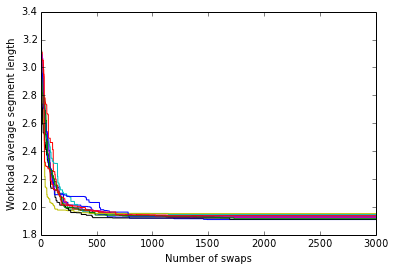

In [30]:
for run in range(10):
    workload_plot(qwerty, 3000)

This plot is even more interesting. (Note: on most browsers you can drag the lower-right corner of the plot to make it bigger.) I note the following:

* Each line follows a slightly different path (because the swaps are random).
* The lines are grouped very tightly together; the variance is small.  Almost everywhere, the difference between the best line and the worst line is about 0.2 or less. By the end, almost all the lines are between 1.9 and 2.0.
* We make rapid progress, decreasing from 3.2 to around 2.2 in about 200 swaps, and to around 2.0 in about 500 swaps.
* After 1000 swaps, progress is slow, and after 2000 swaps progress is very slow.
* Obviously, at any number of swaps the minimum of the 10 lines is less than the average of the 10 lines.

This last point suggests a strategy: *repeat the hillclimbing search multiple times, and take the best result.* Let's investigate that strategy.

Improvement with Repeated Runs
---

Suppose we have a certain budget of time that we are willing to spend to try to find a keyboard
with a low workload average. Suppose the budget is, say, 3,000 swaps and scorings.  How should we spend this budget?  We could have a single run of `improved(qwerty, 3000)`.  Or we could repeat `improved(qwerty, 1000)` three times and take the best of the three results. Or repeat `improved(qwerty, 500)` six times.  From the plot above, it is not clear which of these approaches would be better. (From the plot it is clear that there is rapid progress in the first 500 swaps, so I wouldn't want each run to be much less than that.)

The function `repeated_improved` allows you to decide how to split up your budget between long runs and repeated runs, and always takes the best of the repeated runs:

In [31]:
def repeated_improved(kbd, repeats=20, swaps=1000, scorer=workload_average):
    "Try improved(kbd, swaps) multiple times and take the best result."
    return min([improved(kbd, swaps, scorer) for run in range(repeats)],
               key=scorer)

Let's see what this can do:

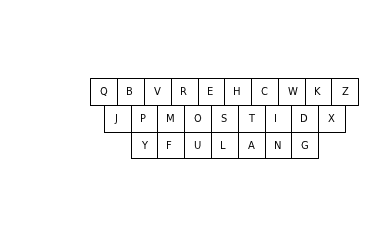

workload average = 2.0 for 3000 swaps repeated once


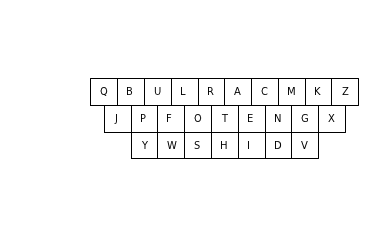

workload average = 2.0 for 1000 swaps repeated three times


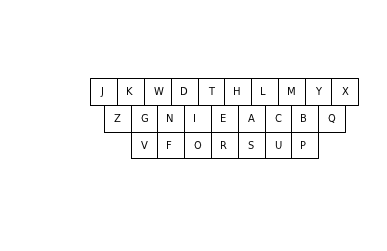

workload average = 2.0 for 500 swaps repeated six times


In [32]:
show_kbd(repeated_improved(qwerty, 1, 3000), "3000 swaps repeated once")
show_kbd(repeated_improved(qwerty, 3, 1000), "1000 swaps repeated three times")
show_kbd(repeated_improved(qwerty, 6, 500),  "500 swaps repeated six times")

Let's do it again, to see how different the result is, and this time let's also check how long it takes:

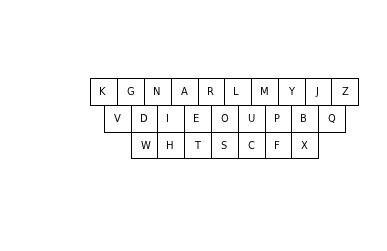

workload average = 1.9 for 3000 swaps repeated once


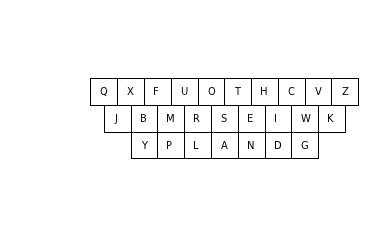

workload average = 1.9 for 1000 swaps repeated three times


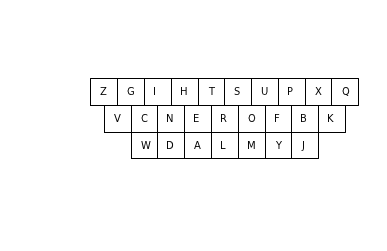

workload average = 1.9 for 500 swaps repeated six times
CPU times: user 3.49 s, sys: 79.1 ms, total: 3.57 s
Wall time: 3.53 s


In [33]:
%%time
show_kbd(repeated_improved(qwerty, 1, 3000), "3000 swaps repeated once")
show_kbd(repeated_improved(qwerty, 3, 1000), "1000 swaps repeated three times")
show_kbd(repeated_improved(qwerty, 6, 500),  "500 swaps repeated six times")

So it looks like in about a second, we can repeatedly get down from a workload average of 3.2 to about 1.9.  The resulting keyboard will not be the same each time, but will tend to have the rare letters in the corners and the common ones in the middle.

What happens if we work a lot harder? Say we have a budget of 30,000 instead of 3,000?

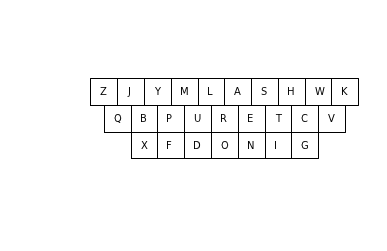

workload average = 1.9 for 30000 swaps repeated once


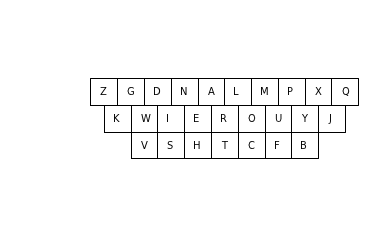

workload average = 1.9 for 2000 swaps repeated fifteen times


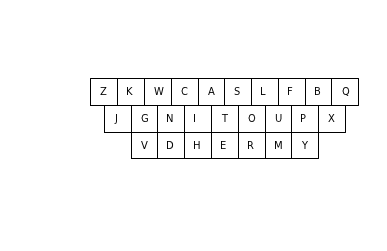

workload average = 1.9 for 500 swaps repeated sixty times
CPU times: user 29 s, sys: 314 ms, total: 29.3 s
Wall time: 29.1 s


In [34]:
%%time 
show_kbd(repeated_improved(qwerty, 1, 30000), "30000 swaps repeated once")
show_kbd(repeated_improved(qwerty, 15, 2000), "2000 swaps repeated fifteen times")
show_kbd(repeated_improved(qwerty, 60, 500),  "500 swaps repeated sixty times")

It looks like spending more time doesn't help.  I can't say we've found the best possible keyboard, but I can say it will take either a very long run time or a more clever algorithm to do much better than 1.9. I can also say that it doesn't seem to matter too much exactly how you manage the budget between repetitions and swaps.

Keys in Different Locations
---

Now let's allow keys  to be in different physical locations.  Rather than allowing complete freedom of movement, we'll start from a few different fixed key layouts and swap keys from there. I'll define three layouts and gather them into a `dict`:

In [35]:
keyboards = {
    'qwerty': Keyboard(('Q W E R T Y U I O P',
                        ' A S D F G H J K L ',  
                        '   Z X C V B N M   ')),

    '4-by-7': Keyboard((' A B C D E F ',
                        'G H I J K L M',
                        ' N O P Q R S ',
                        'T U V W X Y Z')),

    '5-by-6': Keyboard((' A B C D E ',
                        ' F G H I J ',
                        'K L M N O P',
                        ' Q R S T U ',
                        ' V W X Y Z '))
    }

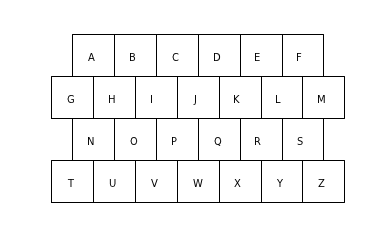

workload average = 2.7 for 4-by-7


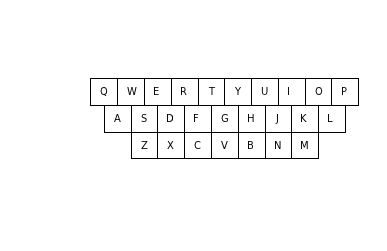

workload average = 3.2 for qwerty


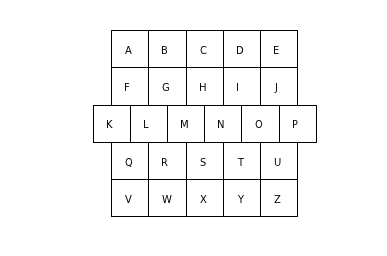

workload average = 2.5 for 5-by-6


In [36]:
# Compare keyboards
for name in keyboards:
    show_kbd(keyboards[name], name)

(**Note:** The plots of different-shaped keyboards have different-sized squares around the keys. Some of the plots have a lot of whitespace around them. If anyone knows an easy way to tell `plot` to display them better, let me know.)

And here is a function to iterate over these layouts, applying `repeated_improved` to each one and displaying the improved keyboard, the workload average before and after improvement, and the time taken:

In [37]:
def report(keyboards, scorer=workload_average):
    "Iterate through a dict of {name: kbd} pairs, showing kbd before and after repeated_improved(kbd)."
    for (name, kbd) in keyboards.items():
        show_kbd(repeated_improved(kbd, scorer=scorer), 
                 'repeated improved ' + name)

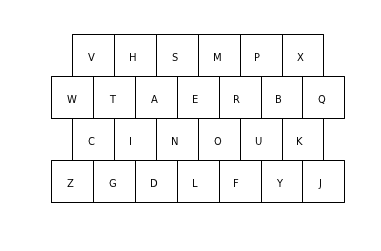

workload average = 1.8 for repeated improved 4-by-7


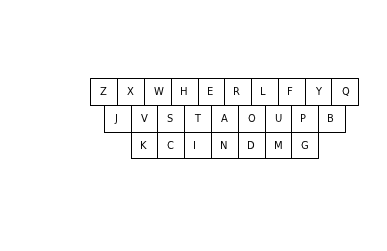

workload average = 1.9 for repeated improved qwerty


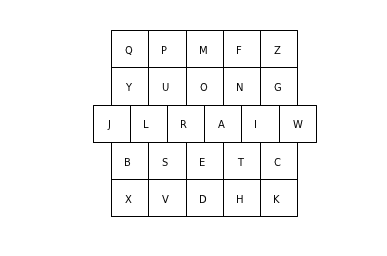

workload average = 1.7 for repeated improved 5-by-6
CPU times: user 19.3 s, sys: 221 ms, total: 19.5 s
Wall time: 19.4 s


In [38]:
%%time
report(keyboards)



So, any keyboard can be improved, but the more compact keyboards with a smaller diameter (`4-by-7` and `5-by-6`) perform slightly better than `qwerty`. 

But ... I still want to know: how close are we coming to the optimal keyboard?  Can we do better than about 1.7 or 1.8?  

One thing to try is to start from a better position.  It is easier to do hillclimbing of Mt. Everest if you start at Everest Base Camp (elevation 17,000 ft) rather than at sea level.  Let's see what we can do.

Better Starting Keyboard
---

What if we started with a keyboard where the most common letters (as measured by the workload text) are in the center?  Then, on average, many of the common segments would tend to be short.  To make this a little more precise:

1. Sort the letters of the alphabet, most frequent first.
2. Find the center of the keyboard.
3. Sort the key locations, closest to center first.
4. Make a new keyboard where the most frequent letter is in the center, the next most frequent is the next closest to center, and so on.


In [39]:
cat = ''.join    ## Function to join strings together into one big string

# Order letters by frequency in TEXT
ordered_letters = cat(sorted(list(qwerty), reverse=True, key=lambda L: TEXT.count(L)))

def recentered(kbd):
    "Put the most frequent letters in the center of this keyboard."
    center = mean(kbd.values())
    ordered_locations = sorted(kbd.values(), key=lambda point: abs(point-center))
    return dict(zip(ordered_letters, ordered_locations))

def mean(numbers): return sum(numbers) / len(numbers)

In [40]:
ordered_letters

'ETAONISRHDLCUMFWYGPBVKXJQZ'

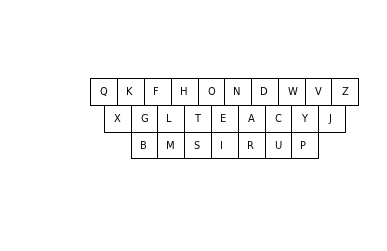

workload average = 2.1 for recentered qwerty


In [41]:
show_kbd(recentered(qwerty), 'recentered qwerty')

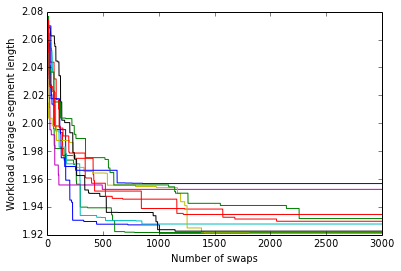

In [42]:
for _ in range(10):
    workload_plot(recentered(qwerty), 3000)

That's interesting.  At first glance it looks like there is much more variability in the lines, compared to the previous plot for the plain `qwerty` keyboard. But that's just an illusion.  The Y axis is much more compressed on this plot; if you look at the numbers on the Y axis, you see the variation is actually *smaller* on this plot.   

Let's try the `report` function:

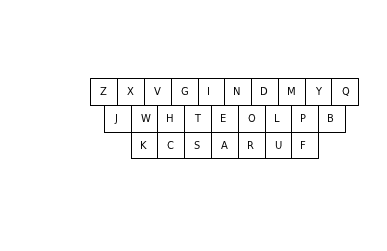

workload average = 1.9 for repeated improved recentered qwerty


In [43]:
show_kbd(repeated_improved(recentered(qwerty)), 'repeated improved recentered qwerty')

So the starting layout of keys seems not to matter very much; you can start with a workload average of 3.2 or 2.1, but either way you end up with an improved version somewhere close to 1.9.

Aside: Lower Bound on Best Keyboard
---

The best improvement on Qwerty that I've seen so far has workload average of 1.86.  But can we estimate a **lower bound** on the best possible permutation of letters?  Here's one approach:  

1. Start with a recentered keyboard (that is, frequent keys are in the center).
2. Now, for each letter `L` on the keyboard, figure out the best possible rearrangement of the other letters to minimize the workload on segments that involve `L`.  The best rearrangement will have the letter that appears in the most segments with `L` closest to `L`; the letter that appears in the next most number of segments with `L` the next closest to `L`, and so on.
3. Do this independently for each letter.  That is, we're summing up the workloads segment by segment, but instead of doing this on one keyboard, we're actually doing it on 26 different keyboards, each one optimized  to give the absolute minimum possible distance for one letter.

I can't quite prove this is a lower bound, because of the assumption that we hold one end of the segments fixed in the recentered-keyboard layout.  I'm pretty confident that the freedom to optimize the other end of each segment for each letter independently means that it is a lower bound, but I can't prove it. Still, here it is:

In [44]:
def workload_lower_bound(kbd=recentered(qwerty), workload=WORKLOAD):
    "Given a keyboard, find a lower bound on the workload average."
    letters = list(kbd)
    def distances(L):
        "Distances to L key, shortest distance first."
        return sorted(abs(kbd[A] - kbd[L]) for A in letters if A != L)
    def counts(L):
        "Workload counts for segments involving L, biggest count first."
        return sorted([workload[segment(A, L)] for A in letters if A != L],
                      reverse=True)
    return (sum(dot_product(distances(L), counts(L)) for L in kbd)
            / sum(workload.values()) / 2) # Divide by 2 because we counted each segment twice

def dot_product(A, B):
    "Σ_i{A_i * B_i}"
    return sum(A[i] * B[i] for i in range(len(A)))

In [45]:
for name in keyboards:
    print name, workload_lower_bound(keyboards[name])

4-by-7 1.5038079626
qwerty 1.60656497359
5-by-6 1.47094590247


So there's a gap of around 0.2 or 0.3 of a key distance between the best keyboard we've found so far, and the lower bound we computed for each keyboard shape.  We don't know where within this gap the actual best keyboard lies. But rather than mind the gap, I'll turn my attention to other matters.

Question 5: How often are two words confused because they have similar paths?
===

When can one word be confused with another?  When their paths are similar (which means that their corresponding letters are in similar locations). For example, on a Qwerty keyboard, the paths for "HELLO" and "JELLO" are similar, because **H** and **J** are adjacent, and the other letters are the same.

<img src="http://norvig.com/gesture.png">

We'd like to know, for a given keyboard, how confusing is it? How many words have paths on the keyboard that can be confused for other words? We have our work cut out for us:

1. Determine what letters could be confused for each other.
2. Determine what words/paths can be confused.
3. Invent some metric for the overall confusingness of a keyboard. 
4. Try to find less-confusing keyboards.

Letter Confusions
---

So, as a first step, we will make a mapping from each key to the keys that it can be confused with. I'll say that any key within a distance of 1.5 units on the keyboard is a **neighboring** key, and thus a potential confusion:

In [46]:
def neighboring_keys(kbd, radius=1.5):
    "Build a dict of {Letter:NeighboringLetters}, e.g. {'Q':'QAW', ...}."
    def neighboring_letters(A): 
        return cat(B for B in kbd if distance(kbd[A], kbd[B]) <= radius)
    return {A: neighboring_letters(A) for A in kbd}

def neighboring_keys(kbd, radius=1.5):
    "Build a dict of {Letter:NeighboringLetters}, e.g. {'Q':'QAW', ...}."
    def neighboring_letters(A): 
        return 
    return {A: cat(B for B in kbd if distance(kbd[A], kbd[B]) <= radius)
            for A in kbd}

cat = ''.join  ## Function to join letters (or strings) into one string

In [47]:
qwerty_neighbors = neighboring_keys(qwerty) 
qwerty_neighbors

{'A': 'AQSWZ',
 'B': 'BGHJNV',
 'C': 'CDGFVX',
 'D': 'CEDFSRXZ',
 'E': 'EDSRW',
 'F': 'CDGFRTVX',
 'G': 'CBGFHTVY',
 'H': 'BGHJNUVY',
 'I': 'IKJOU',
 'J': 'BIHKJMNU',
 'K': 'IKJMLON',
 'L': 'KMLOP',
 'M': 'KJMLN',
 'N': 'BHKJMN',
 'O': 'IKLOP',
 'P': 'LOP',
 'Q': 'AQW',
 'R': 'EDFRT',
 'S': 'AEDSWXZ',
 'T': 'GFRTY',
 'U': 'IHJUY',
 'V': 'CBGFHV',
 'W': 'AEQSW',
 'X': 'CDFSXZ',
 'Y': 'GHUTY',
 'Z': 'ADSXZ'}

We see, for example, that **Q**, off in the corner, has only **A**, **W**, and itself as neighbors, while **G**, in the middle of the keyboard, has 8 neighbors. 

Word Confusions
---

Consider each of the letters in the word "HELLO," and all the possible choices for neighbors of each letter:

In [48]:
choices = [qwerty_neighbors[L] for L in 'HELLO']
choices

['BGHJNUVY', 'EDSRW', 'KMLOP', 'KMLOP', 'IKLOP']

Think of this as five "columns" of letters, and if we pick one letter from each column, we get a path that is formed by letters that are each confusions of letters in the original word, and so the whole path is a confusion for the original word.  So "JELLO" is a confusion for "HELLO", as would be "BEKKI" (formed by taking the first possible neighbor for each of the five letters) and "YWPPP" (formed by taking the last possible neighbors), except they are not words.

It turns out that there is a library function, `itertools.product`, that will take an iterable of alternative choices, and generate all possible ways of assembling a sequence consisting of one selection (letter) from each alternative choice.

In [49]:
paths = {cat(letters) for letters in itertools.product(*choices)}

How many paths are there?

In [50]:
len(paths)

5000

Let's look at a few of them:

In [51]:
random.sample(paths, 8)

['JSMML', 'JRPML', 'VWMPP', 'JSPML', 'JDLML', 'VWPPK', 'GRLLK', 'BWOMK']

And let's see all the paths that are also words:

In [52]:
WORDS & paths

{'BROMO', 'BROOK', 'HELLO', 'JELLO'}

Only 4 out of 5000!  That's pretty good, but it means "HELLO" is still a confusing word. We can wrap this up as the function  `confusions`:

In [53]:
def confusions(word, neighbors=neighboring_keys(qwerty), words=WORDS):
    "All valid words whose paths could be confused with the path for the given word."
    choices = [neighbors[L] for L in word]
    return {cat(letters) for letters in itertools.product(*choices)} & words

In [54]:
confusions('HELLO')

{'BROMO', 'BROOK', 'HELLO', 'JELLO'}

In [55]:
confusions('WORLD')

{'ALTOS', 'EIDOS', 'SIDLE', 'SKEPS', 'WIELD', 'WORKS', 'WORLD', 'WORMS'}

In [56]:
confusions('TESTING')

{'FEARING',
 'FRAYING',
 'GEARING',
 'GRATING',
 'GRAYING',
 'GREYING',
 'REARING',
 'REEFING',
 'RESTING',
 'TEARING',
 'TESTING'}

So far, so good.  But I'm worried about the efficiency of `confusions` for longer words.  

More Efficient `confusions`
---

Consider:

In [57]:
%time confusions('SOMETHING')

CPU times: user 3.71 s, sys: 623 ms, total: 4.33 s
Wall time: 4.2 s


{'SOMETHING'}

It took (on my computer) 4 seconds to compute this.  Why so long? Let's count:

In [58]:
[len(neighboring_keys(qwerty)[L]) for L in 'SOMETHING']

[7, 5, 5, 5, 5, 8, 5, 6, 8]

There are 7 &times; 5 &times; 5 &times; 5 &times; 5 &times; 8 &times; 5 &times; 6 &times; 8 = 8,400,000 paths for `confusions` to consider. Looking at them all takes 4 seconds, but for most of these paths, we're wasting our time.  For example, one choice for the first two neighboring letters of 'SOMETHING' is 'XP', but 'XP' does not start any word in the dictionary.  Nevertheless, `itertools.product` will generate 240,000 combinations that start with 'XP', and will then rule them out one at a time. It would be better to stop as soon as we see 'XP', and never consider continuations of this path.

So that gives us the key idea for a more efficient version of `confusions`: *only follow paths that form a prefix of at least one word.*  

So, first we need to define the set of prefixes:

In [59]:
def prefixes(words):
    "Return a set of prefixes (1 to N characters) of this collection of words."
    return {word[:i] for word in words for i in range(1, len(word)+1)}

In [60]:
prefixes(['THESE', 'THEY', 'THOSE'])

{'T', 'TH', 'THE', 'THES', 'THESE', 'THEY', 'THO', 'THOS', 'THOSE'}

Let's generate the prefixes of all the words, and check how many there are:

In [61]:
PREFIXES = prefixes(WORDS)

len(PREFIXES), len(WORDS)

(395184, 178691)

We can describe the more efficient version of the `confusions` algorithm:

1. Maintain a queue of partial paths, where a partial path is a string representing choices for neighboring letters for a prefix of the word. For example, 'HE' and 'JE' are both partial paths for the word 'HELLO'.  Initialize the queue to have just one partial path, the empty string.
2. Remove a partial path from the queue. Find all possible ways to extend the path by adding a neighboring letter, but only if doing so creates a path that is a prefix of some word in the dictionary.  For example, given the word 'HELLO', and the partial path 'JE', consider all the neighbors of 'L' (namely, 'K', 'M', 'L', 'O', or 'P'), but only 'JEM', 'JEL', and 'JEO' are prefixes of words, so add just those to the queue.
3. When a partial path reaches the same length as the word ('HELLO' in this example), then don't extend it any farther; instead check to see if the path is a word.  If it is, add it to the set of paths/words that form the result.

In [62]:
def confusions(word, neighbors=neighboring_keys(qwerty), words=WORDS, prefixes=PREFIXES):
    "All valid words whose paths could be confused with the path for this word."
    results = set() # A set of words that are confusions of 'word'
    Q = ['']        # A queue of partial paths 
    while Q:
        path = Q.pop()
        if len(path) < len(word):
            for L in neighbors[word[len(path)]]:
                if path + L in prefixes:
                    Q.append(path + L)
        elif path in words:
            results.add(path)
    return results

Let's do one quick check to see if we are getting the same answers as before:

In [63]:
confusions('HELLO')

{'BROMO', 'BROOK', 'HELLO', 'JELLO'}

And let's see how much faster this version is:

In [64]:
%time confusions('SOMETHING')

CPU times: user 543 µs, sys: 155 µs, total: 698 µs
Wall time: 586 µs


{'SOMETHING'}

We went from about 4 seconds to under a millisecond: that's more than 4000 times faster!  We can do a bigger test:

In [65]:
def words(text): 
    "Extract a list of all words from a text. Make everything uppercase."
    return re.findall('[A-Z]+', text.upper())

test_words = words("""Hello world! Testing something: confusion paths on 
multiple distinct inputs of various lengths. See if everything works 
perfect, or poorly, or somewhere between the extremes.""")

def test_confusions(words=test_words):
    "Run through some test words, printing and summarizing the confusions."
    total = 0
    for word in sorted(set(words)):
        others = sorted(set(confusions(word)) - {word})
        total += len(others)
        print('{}({}): {}'.format(word, len(others), ' '.join(others)))
    print 'Total of {} confusions for {} words'.format(total, len(words))

In [66]:
%time test_confusions()

BETWEEN(2): BERSEEM BERSERK
CONFUSION(2): CONCISION CONTUSION
DISTINCT(0): 
EVERYTHING(0): 
EXTREMES(3): ESTEEMED EXTERNES SCREENED
HELLO(3): BROMO BROOK JELLO
IF(7): ID IT OD OF OR OX UT
INPUTS(6): IMPURE IMPUTE KNOUTS OBLIGE UMPIRE UNPURE
LENGTHS(0): 
MULTIPLE(0): 
OF(6): ID IF IT OD OR OX
ON(3): IN OH OM
OR(7): ID IF IT OD OE OF PE
PATHS(7): LARGE LARVA LATHE LATHS OATHS PARGE PARVE
PERFECT(2): PREFECT PRETEXT
POORLY(1): LIKELY
SEE(20): ADD ADS ARE ARS ASS AWE DEE DEW EDS ERE ERR ERS ESS EWE SER SEW WED WEE ZED ZEE
SOMETHING(0): 
SOMEWHERE(1): WINDSURFS
TESTING(10): FEARING FRAYING GEARING GRATING GRAYING GREYING REARING REEFING RESTING TEARING
THE(5): FUD FUR RUE RYE TYE
VARIOUS(3): CARIOUS CAROLUS FATUOUS
WORKS(13): AIRNS AKELA AKENE ALTOS EIDOS SIDLE SKENE SORNS SPEND WIDOW WIELD WORLD WORMS
WORLD(7): ALTOS EIDOS SIDLE SKEPS WIELD WORKS WORMS
Total of 108 confusions for 25 words
CPU times: user 7.21 ms, sys: 2.06 ms, total: 9.27 ms
Wall time: 7.84 ms


So, 108 confusions for 25 test words, or an average of 4 confusions per word.

Visualizing Paths on a Keyboard
----

To determine if these `confusions` are good ones, let's build something to visualize paths on a keyboard.  


I'll add functionality to `plot_kbd` to call the new function `plot_paths` and implement that:



In [67]:
def plot_kbd(kbd, K=20, words=()):
    "Plot the keyboard with square keys, K units on a side."
    H = K / 2       ## (K is Key width/height; H is half K)
    # Draw a square for each key, and plot paths for words
    for L in kbd:
        x, y = K * kbd[L].x, -K * kbd[L].y
        plot_square(x, y, H, label=L)
    plot_paths(kbd, K, words)
    # Show the plot and print the workload average
    plt.axis('equal'); plt.axis('off'); plt.show()
    
def plot_paths(kbd, K, words):
    "Plot paths for each word."
    for (i, word) in enumerate(words):
        Xs = [+K * kbd[L].x for L in word]
        Ys = [-K * kbd[L].y for L in word]
        plt.plot(Xs, Ys, '-o')

Let's see how it works:

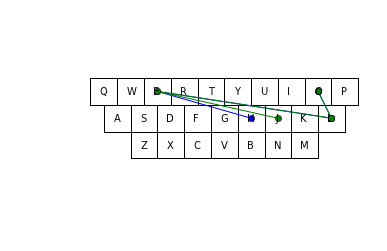

In [68]:
plot_kbd(qwerty, words=['HELLO', 'JELLO'])

OK, we're on the right track, but I see three problems: first, the letters are obscured by the circles.  Second, when the paths are the same (for the "ELLO" part), they overwrite each other.  And third, there is no indication what direction the path is going in ("OLLEH" would look the same as "HELLO").  

I have an idea to fix the first two problems (and I will ignore the third for now).  Instead of plotting the circle in the center of the key, offset it to one of the corners of the key.  Have each path offset to a different corner; that way they won't overlap (at least for up to four paths).  

In [69]:
def plot_paths(kbd, K, words):
    "Plot paths for each word, each with a different offset (and color)."
    Q = K / 4  ## Q is a quarter of a key width
    offsets = [Point(-Q, -Q), Point(-Q, +Q),  Point(Q, +Q), Point(Q, -Q)]
    for (i, word) in enumerate(words):
        Xs = [+K * kbd[L].x + offsets[i % 4].x for L in word]
        Ys = [-K * kbd[L].y + offsets[i % 4].y for L in word]
        plt.plot(Xs, Ys, '-o')

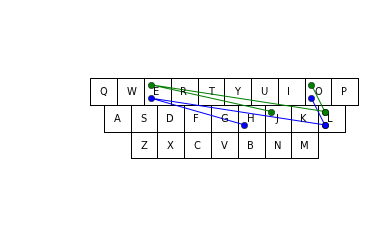

In [70]:
plot_kbd(qwerty, words=['HELLO', 'JELLO'])

That looks much better!  Let's look at all four confusions of "HELLO":

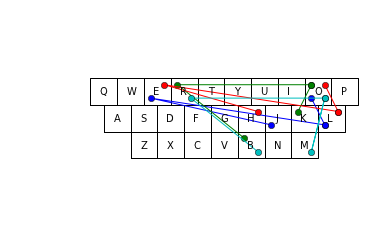

In [71]:
plot_kbd(qwerty, words=confusions('HELLO'))

Not all the paths are very close to each other. This suggests that maybe they shouldn't all be confusions of 'HELLO'.  Let's see if we can get less confusion.

Less Confusion
---

Let's concentrate on 'JELLO' instead of 'HELLO':

In [72]:
confusions('JELLO')

{'BROMO', 'BROOK', 'HELLO', 'IROKO', 'JELLO'}

Two confusions are 'JELLO' and 'BROOK':

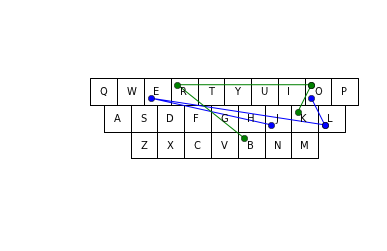

In [73]:
plot_kbd(qwerty, words=['JELLO', 'BROOK'])

I think these two paths should not be confusions of each other. To see why, I'll start with just the first segment of each path:

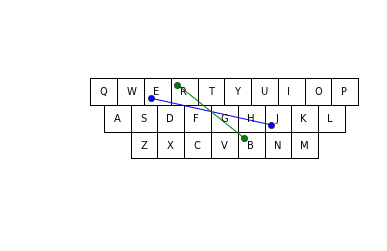

In [74]:
plot_kbd(qwerty, words=['JE', 'BR'])

Note that 'J' and 'B' are within 1.5 units of each other, as are 'E' and 'R' (as all neighboring letters must be).  The issue, as I see it, is that 'B' is offset  to the left from 'J' while 'R' is offset to the right.  Together, that seems like too much difference to allow these segments to be confusions of each other.  How much difference is it?  We can define `JE` and `BR` as the vectors for each segment, and find the difference (or distance) between these two vectors:

In [75]:
JE = qwerty['E'] - qwerty['J']
BR = qwerty['R'] - qwerty['B']
distance(JE, BR)

2.23606797749979

That seems like too big a difference&mdash;maybe we should limit the difference.
Let's experiment with a function, `similar_segments`, that decides whether the last segment in a path is similar to the corresponding segment in a word:

In [76]:
def similar_segments(kbd, path, word):
    "Do the last two letters of path form a similar segment to corresponding letters of word?"
    n = len(path)
    if n < 2: return True
    # Define endpoints (P1, P2), (W1, W2); then vectors P and W; then difference between.
    (P1, P2), (W1, W2) = (path[n-2:n], word[n-2:n])
    P = kbd[P2] - kbd[P1]
    W = kbd[W2] - kbd[W1]
    return distance(P, W) < 2

We can play with `similar_segments` to make sure it looks right:

In [77]:
similar_segments(qwerty, 'BR', 'JELLO')

False

In [78]:
similar_segments(qwerty, 'HE', 'JELLO')

True

In [79]:
similar_segments(qwerty, 'HEP', 'JELLO')

True

In [80]:
similar_segments(qwerty, 'J', 'JELLO')

True

Now we will modify `confusions` to call `similar_segments`, and then re-test:

In [81]:
def confusions(word, neighbors=neighboring_keys(qwerty), 
               words=WORDS, prefixes=PREFIXES, kbd=qwerty):
    "All valid words whose paths could be confused with the path for this word."
    results = set() # A set of words that are confusions of 'word'
    Q = ['']        # A queue of partial paths 
    while Q:
        path = Q.pop()
        if len(path) < len(word):
            for L in neighbors[word[len(path)]]:
                newpath = path + L
                if (newpath in prefixes) and similar_segments(kbd, newpath, word):
                    Q.append(newpath)
        elif path in words:
            results.add(path)
    return results

In [82]:
test_confusions()

BETWEEN(2): BERSEEM BERSERK
CONFUSION(2): CONCISION CONTUSION
DISTINCT(0): 
EVERYTHING(0): 
EXTREMES(1): ESTEEMED
HELLO(1): JELLO
IF(5): ID IT OF OR UT
INPUTS(4): IMPURE IMPUTE KNOUTS UNPURE
LENGTHS(0): 
MULTIPLE(0): 
OF(6): ID IF IT OD OR OX
ON(3): IN OH OM
OR(5): ID IF OD OE OF
PATHS(6): LARGE LARVA LATHE LATHS OATHS PARGE
PERFECT(0): 
POORLY(1): LIKELY
SEE(16): ADD ADS ASS AWE DEE DEW ERE ERR ERS EWE SER SEW WED WEE ZED ZEE
SOMETHING(0): 
SOMEWHERE(0): 
TESTING(6): FEARING GEARING GREYING REARING RESTING TEARING
THE(3): RUE RYE TYE
VARIOUS(2): CARIOUS CAROLUS
WORKS(6): AIRNS ALTOS SIDLE SORNS WORLD WORMS
WORLD(6): ALTOS SIDLE SKEPS WIELD WORKS WORMS
Total of 75 confusions for 25 words


We went from 108 down to 75 confusions.  Studying the results, this looks like an improvement. For "HELLO", only "JELLO" remains, which looks good. But there are still some confusions that don't look right. For example:

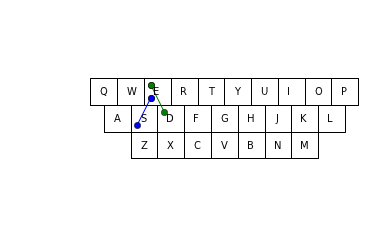

In [83]:
plot_kbd(qwerty, words=['SEE', 'DEE'])

To me, these look different because the SE segment is going to the right while the DE segment is going to the left.  Yet they are considered similar:

In [84]:
similar_segments(qwerty, 'DE', 'SEE')

True

Let's extend `similar_segments` to make it check that two corresponding segments aren't going in opposite directions.  If one goes right, the other can't go left; if one goes down, the other can't go up.

How do I test that?  We have the vectors for each segment; we want to make sure that the `x` components of the two vectors don't have opposite signs, and that the `y` components don't have opposite signs.  One way to tell if two numbers have opposite sign is to multiply them together and see if the result is negative.

In [85]:
def similar_segments(kbd, path, word):
    "Do the last two letters of path form a similar segment to corresponding letters of word?"
    n = len(path)
    if n < 2: return True
    # Define endpoints (P1, P2), (W1, W2); then vectors P and W; then difference between.
    (P1, P2), (W1, W2) = (path[n-2:n], word[n-2:n])
    P = Point(kbd[P2] - kbd[P1])
    W = Point(kbd[W2] - kbd[W1])
    return (distance(P, W) < 2) and (P.x * W.x >= 0) and (P.y * W.y >= 0)

We can re-test once more:

In [86]:
test_confusions()

BETWEEN(2): BERSEEM BERSERK
CONFUSION(2): CONCISION CONTUSION
DISTINCT(0): 
EVERYTHING(0): 
EXTREMES(0): 
HELLO(1): JELLO
IF(5): ID IT OF OR UT
INPUTS(1): KNOUTS
LENGTHS(0): 
MULTIPLE(0): 
OF(6): ID IF IT OD OR OX
ON(3): IN OH OM
OR(5): ID IF OD OE OF
PATHS(6): LARGE LARVA LATHE LATHS OATHS PARGE
PERFECT(0): 
POORLY(1): LIKELY
SEE(13): ADD ADS ASS AWE ERE ERR ERS SER SEW WED WEE ZED ZEE
SOMETHING(0): 
SOMEWHERE(0): 
TESTING(6): FEARING GEARING GREYING REARING RESTING TEARING
THE(3): RUE RYE TYE
VARIOUS(2): CARIOUS CAROLUS
WORKS(6): AIRNS ALTOS SIDLE SORNS WORLD WORMS
WORLD(6): ALTOS SIDLE SKEPS WIELD WORKS WORMS
Total of 68 confusions for 25 words


Now we're down to 68 confusions, from our initial 108.    I think I'll declare victory on  `confusions`, and move on to answer the question we *really* want to answer.

Average Confusions of a Keyboard on a Workload
===

The question is: how confusing is a keyboard across a workload of words?  First we'll need a workload of words.  That's easy because we already have some `TEXT`, and the function `words` to extract words, `Counter` to otal them up, and `normalize` to make them sum to 1.0.  We'll call the workload of words `WORDLOAD`:

In [87]:
WORDLOAD = normalize(Counter(words(TEXT)))

In [88]:
len(WORDLOAD)

12020

This tells us there were 12,020 distinct words.  We can see the most common words:

In [89]:
WORDLOAD.most_common(10)

[('THE', 0.0704858090087631),
 ('OF', 0.03601344319907194),
 ('AND', 0.03006522567400811),
 ('TO', 0.026505393770862834),
 ('A', 0.02193902792705188),
 ('IN', 0.02065953562959551),
 ('I', 0.0174409016724386),
 ('WAS', 0.013062194698921246),
 ('THAT', 0.012993955109723572),
 ('IT', 0.012794922974563694)]

And we can find all the confusing words:

In [90]:
WORDLOAD_PREFIXES = prefixes(WORDLOAD)

CONFUSING = [w for w in WORDLOAD 
             if len(confusions(w, words=WORDLOAD, prefixes=WORDLOAD_PREFIXES)) > 1]

One metric for confusingness is the percentage of words that are confused with other words:

In [91]:
print(len(CONFUSING))
print(len(WORDLOAD))
print(len(CONFUSING) / len(WORDLOAD))

3164
12020
0.263227953411


So 26% of the words in the dictionary are confusing (on a Qwerty keyboard).  But it seems more important if "THE" is confusing than if "REMONSTRATED" is.  We can weight each word by its frequency in `WORDLOAD`:

In [92]:
sum(WORDLOAD[w] for w in WORDLOAD 
    if len(confusions(w, words=WORDLOAD, prefixes=WORDLOAD_PREFIXES)) > 1)

0.5521549493605586

That's unfortunate. A majority (55%) of words in running text are confusing. (Unfortunate&mdash;but it shouldn't be surprising. A long word is unlikely to be confused with other words, because a long word has many segments, and if just one segment differs, then there is no confusion.  A short word has only a few segments, and thus fewer chances to differentiate itself from other words.  Running text is mostly short words, while the dictionary is mostly long words; that's why running text has a higher confusingness percentage.)

We can wrap this computation up in a function:

In [93]:
def confusingness(kbd, wordload=WORDLOAD, prefixes=WORDLOAD_PREFIXES):
    "The proportion of words in wordload that are confused with other words."
    neighbors = neighboring_keys(kbd)
    return sum(WORDLOAD[w] for w in WORDLOAD 
               if len(confusions(w, neighbors, wordload, prefixes)) > 1)

And we can make it part of `show_kbd`:

In [94]:
def show_kbd(kbd, name='keyboard'):
    "Plot a keyboard and print statistics about it."
    plot_kbd(kbd)   
    print('workload average = {:.1f}; confusingness = {:.0%} for {}'
          .format(workload_average(kbd), confusingness(kbd), name))

Let's see how our keyboards do on this new metric:

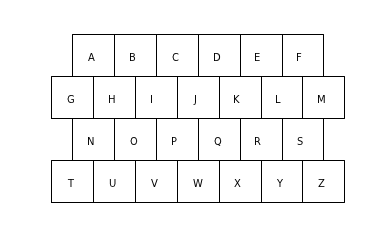

workload average = 2.7; confusingness = 37% for 4-by-7


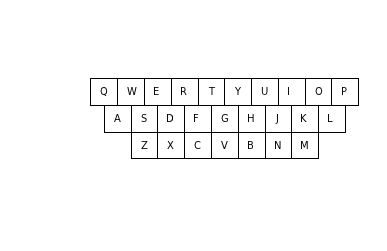

workload average = 3.2; confusingness = 55% for qwerty


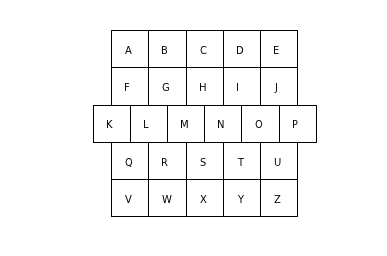

workload average = 2.5; confusingness = 46% for 5-by-6


In [95]:
for name in keyboards:
    show_kbd(keyboards[name], name)

It looks like Qwerty is the worst on all counts. Now we can try the improved keyboards.  Remember that we are still working to improve the workload average, so any change to confusingness will be incidental, not planned.

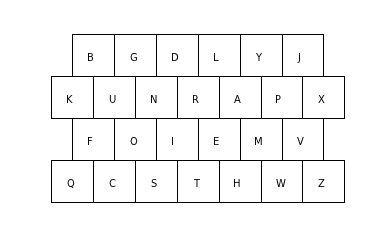

workload average = 1.8; confusingness = 29% for repeated improved 4-by-7


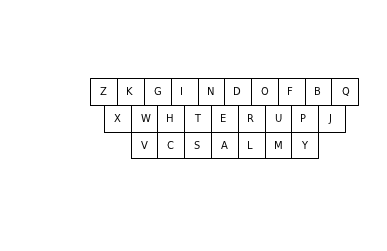

workload average = 1.9; confusingness = 35% for repeated improved qwerty


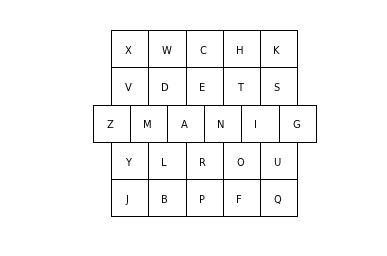

workload average = 1.7; confusingness = 35% for repeated improved 5-by-6


In [96]:
report(keyboards)

Good to see that the "improved" keyboards actually improve confusingness, as well as workload average. Of course, we haven't yet explicitly searched for  a keyboard with a good confusingness  score. Could we?

Question 6: Is there a Keyboard that Minimizes Confusion?
===

Unfortunately, we won't get very far towards solving this problem.  Consider:

In [97]:
%time confusingness(qwerty)

CPU times: user 3.62 s, sys: 174 ms, total: 3.79 s
Wall time: 3.68 s


0.5521549493605586

In [98]:
%time workload_average(qwerty)

CPU times: user 375 µs, sys: 126 µs, total: 501 µs
Wall time: 419 µs


3.2333097802127644

Computing `confusingness` takes thousands of times longer than computing `workload_average`, so `confusingness`, as it stands, is not a good candidate for a scorer function in the inside loop of `improved`.  We'd need some way of factoring `confusingness` into pieces that can be recomputed incrementally to make things go faster.  So for now, I'll make a token effort of scoring with confusingness, but with a paltry 20 swaps (designed to take around a minute of computation):

CPU times: user 47.9 s, sys: 1.21 s, total: 49.1 s
Wall time: 48.3 s


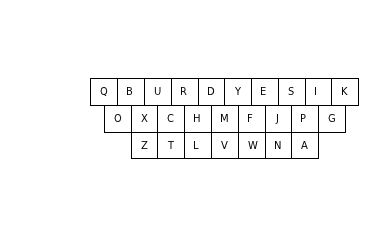

workload average = 3.1; confusingness = 16% for keyboard


In [99]:
%time kbd = improved(qwerty, swaps=20, scorer=confusingness)
show_kbd(kbd)

This did indeed reduce confusingness; not bad for only 20 swaps. Too bad the workload average got worse.

Question 7: Is there a Keyboard that Maximizes User Satisfaction?
===

What is user satisfaction? I don't know, but for now I'll approximate satisfaction (or rather, *dissatisfaction*, since lower scores are better) with a combined score that is the average of workload average and 6 times confusingness. Why 6 times? Because our best scores are around 1.8 for workload average and 0.3 for confusingness, and I want both factors to weigh about the same.

First we'll define the combined scorer function:

In [100]:
def combined_scorer(kbd):
    "The average of workload average and 6 * confusingness."
    return mean([workload_average(kbd), 6 * confusingness(kbd)])

We can incorporate the combined score into `show_kbd`:

In [101]:
def show_kbd(kbd, name='keyboard'):
    "Plot a keyboard and print statistics about it."
    plot_kbd(kbd)   
    W = workload_average(kbd)
    C = confusingness(kbd)
    print('workload average = {:.1f}; confusingness = {:.0%}; combined = {:.1f} for {}'
          .format(W, C, mean([W, 6 * C]), name))

Let's get a baseline for our keyboards to see which performs best on the combined metric.

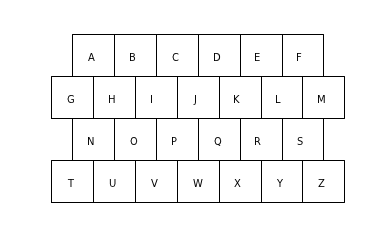

workload average = 2.7; confusingness = 37%; combined = 2.5 for 4-by-7


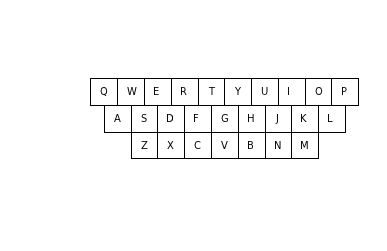

workload average = 3.2; confusingness = 55%; combined = 3.3 for qwerty


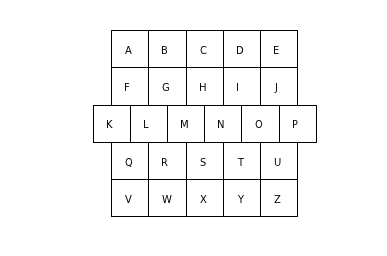

workload average = 2.5; confusingness = 46%; combined = 2.6 for 5-by-6


In [102]:
for name in keyboards:
    show_kbd(keyboards[name], name)

It looks like 4-by-7 gets the best score.  Let's try a few swaps to improve it:

CPU times: user 42.3 s, sys: 725 ms, total: 43 s
Wall time: 42.6 s


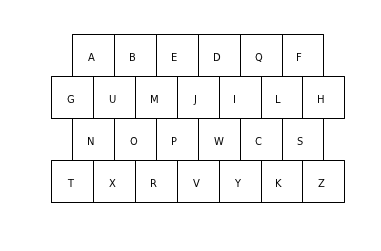

workload average = 2.9; confusingness = 6%; combined = 1.6 for keyboard


In [104]:
%time kbd = improved(keyboards['4-by-7'], swaps=30, scorer=combined_scorer)
show_kbd(kbd)

Success!  We were in fact able to make progress on the combined metric.  If we could run 30,000 swaps instead of just 30, we could probably do even better. To do so would require either (1) more computers, (2) more patience, or (3) more efficient algorithms.  I'll leave it up to you to make more progress.

**Note**: Each time this notebook is run, different random results can occur.  I'll record a keyboard found by one
of the good runs (only 6% confusingness) here, just in case another run is not as good:

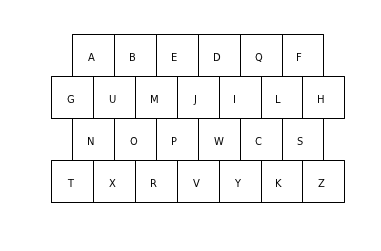

workload average = 2.9; confusingness = 6%; combined = 1.6 for keyboard


In [107]:
show_kbd(Keyboard((' A B E D Q F ',
                   'G U M J I L H',
                   ' N O P W C S ',
                   'T X R V Y K Z')))

Summary
=====
  
  So where are we? Let's revisit our initial questions and see what answers we have:
  
 1. What words have the longest path length? <br>**Answered**: "PALEOMAGNETISMS" etc.
 2. What words have the highest ratio of path length to word length? <br>**Answered**: "PALAPA" etc.
 3. What is the average segment length, over a typical typing work load? <br>**Answered**: 3.23 keys, for Qwerty keyboard, on our sample workload.
 4. Is there a better keyboard layout to minimize the average segment length over a work load?  <br>**Answered**: Yes, many layouts at around 1.9 on Qwerty; or 1.7 or 1.8 on more square keyboards.
 5. How often are two words confused because they have similar paths? <br>**Answered**: On Qwerty, 26% of the words in a small dictionary, and 55% of the words in running text have at least one possible confusion. Other layouts are worse.
 6. Is there a better keyboard layout to minimize confusion? <br>**Partially Answered**: We found a keyboard with less confusingness than Qwerty.  The computation of confusingness takes too long to do very much hillclimbing search.  
 7. Is there a better keyboard layout to maximize overall user satisfaction? <br>**Partially Answered**: We defined a combined metric, and found
a keyboard with a better score. There are no doubt better metrics, and better keyboards to be found.
 



Going Beyond
===

Now it is your turn to answer the open questions, or make up some questions of your own.  Good luck! Here are a few ideas to get you started:

* Hillclimbing just keeps the one best keyboard it has found so far.  Other optimization techniques such as
[beam search](http://en.wikipedia.org/wiki/Beam_search) or [genetic algorithms](http://en.wikipedia.org/wiki/Genetic_algorithm)  or [ant colony optimization](http://en.wikipedia.org/wiki/Ant_colony_optimization_algorithms) maintain several candidates at a time. Is that a good idea?

* The code in this notebook emphasises clarity, not efficiency.  Can you modify the code (or perhaps port it to another language) and make it twice as efficient? 10 times? 100 times?

* What other factors do you think are important to user satisfaction with a keyboard.  Can you measure them?

* Consider the 5 paths below. They all start at 'P', move in a straight line to 'T', and then go to 'S', but they all make different stops along the top row. In other words, the 5 paths all trace exacty the same lines, so they are very confusing, but our definition of  `confusions` makes most of them different. Can you think
of a better way to handle confusions for paths like this?

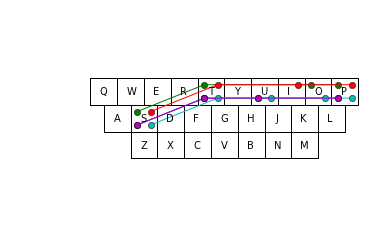

In [108]:
plot_kbd(qwerty, words=['PUTS', 'POTS', 'PITS', 'POUTS', 'PUTTS'])